In [1]:
from pathlib import Path

funcs_csv = Path('/home/cls0027/exp_builds/astera.exp/rundata/run1/6.fighter/functions.csv')
locals_csv = Path('/home/cls0027/exp_builds/astera.exp/rundata/run1/6.fighter/locals.csv')

import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

# TODO: TESTING THIS...
pd.options.mode.copy_on_write = True

# NOTE: once this works, may want to adjust to work with overall csv files (not binary-specific)
funcs_df = pd.read_csv(funcs_csv)
locals_df = pd.read_csv(locals_csv)

In [2]:
from astlib import StructDatabase
#!ls ~/exp_builds/astera.exp/rundata/run1/0.fighter/0.fighter.debug.sdb

debug_sdb_file = Path.home()/'exp_builds/astera.exp/rundata/run1/6.fighter/6.fighter.debug.sdb'
strip_sdb_file = Path.home()/'exp_builds/astera.exp/rundata/run1/6.fighter/6.fighter.sdb'
sdb = StructDatabase.from_json(debug_sdb_file)
strip_sdb = StructDatabase.from_json(strip_sdb_file)

In [3]:
sid = sdb.sids_by_name['r_camera'][0]
sdb.structs_by_id[sid]

struct r_camera {
	0x0: float[3] position
	0xc: float[2] size
	0x14: float rotation
	0x18: float[4][4] view
	0x58: float[4][4] projection
	0x98: float near
	0x9c: float far
}

In [4]:
locals_df.loc[locals_df.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)].groupby('TypeSeq_Debug').count()

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,Type_Debug,LocType_Debug,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,HasDWARF,TypeJson_Debug,BinaryId
TypeSeq_Debug,,,,,,,,,,,,,,,,,,
"ARR,STRUCT",4,4,4,4,4,0,4,4,4,4,4,4,0,4,4,4,4,4
"PTR,PTR,STRUCT",10,10,10,10,10,4,10,10,10,10,10,10,4,10,10,10,10,10
"PTR,STRUCT",444,444,444,444,444,242,444,444,444,444,444,444,242,444,444,444,444,444
STRUCT,59,59,59,59,59,0,59,59,59,59,59,59,0,59,59,59,59,59


In [5]:
# start with PTR->STRUCT, this is likely the easiest

var_row = locals_df[locals_df.TypeSeq_Debug=='PTR,STRUCT'].iloc[0]
var_row

FunctionStart                     1090825
Signature                        27,64,89
Name_Strip                          lVar2
Type_Strip                          int64
LocType_Strip                    register
LocRegName_Strip                      rax
LocOffset_Strip                         0
TypeCategory_Strip                BUILTIN
TypeSeq_Strip                       int64
Name_Debug                          asset
Type_Debug                       asset_t*
LocType_Debug                    register
LocRegName_Debug                      rax
LocOffset_Debug                       0.0
TypeCategory_Debug                    PTR
TypeSeq_Debug                  PTR,STRUCT
HasDWARF                            False
TypeJson_Debug        {"kind": "Pointe...
BinaryId                                6
Name: 15, dtype: object

Read datatype from JSON, since we have the struct db we have the layout:

In [6]:
import astlib
from varlib.datatype import datatype_from_json_str

dt = datatype_from_json_str(var_row.TypeJson_Debug, sdb)
dt.pointed_to.layout

0x0: uint32 uid
0x8: uchar* data
0x10: uint32 data_length
0x18: char* name
0x20: int32 chunk_start
0x24: int32 chunk_length
0x28: uchar fs
0x29: uchar filled
0x2a: uchar req
0x2b: uchar req_free
0x2c: uchar chunk

Ok, so let's collect all the member accesses from the Debug AST for this variable

In [7]:
var_name = var_row.Name_Debug
strip_name = var_row.Name_Strip
func_addr = var_row.FunctionStart
bin_id = var_row.BinaryId
print(f'Binary: {bin_id}, func {func_addr:#x}, local debug var "{var_name}", local strip var  "{strip_name}"')

Binary: 6, func 0x10a509, local debug var "asset", local strip var  "lVar2"


In [8]:
func_row = funcs_df[funcs_df.FunctionStart==func_addr].iloc[0]
debug_ast_jsonfile = func_row.AstJson_Debug
strip_ast_jsonfile = func_row.AstJson_Strip
# print(debug_ast_jsonfile)
debug_ast = astlib.read_json(debug_ast_jsonfile, sdb)
strip_ast = astlib.read_json(strip_ast_jsonfile, strip_sdb)

In [9]:
# --------------------------------------------------
# TODO: pick up here and VISIT the AST to collect all MemberExpr
# nodes that involve our target variable
# --------------------------------------------------
# --> or collect ALL MemberExprs and try to map each of them to StripAST

# NOTE: see initial start on implementation in basic_dataset for reference...

vdecl = debug_ast.inner[-1].inner[-1].inner[1].inner[0]
vdecl.dtype.pointed_to

struct asset_t {
	0x0: uint32 uid
	0x8: uchar* data
	0x10: uint32 data_length
	0x18: char* name
	0x20: int32 chunk_start
	0x24: int32 chunk_length
	0x28: uchar fs
	0x29: uchar filled
	0x2a: uchar req
	0x2b: uchar req_free
	0x2c: uchar chunk
}

In [10]:
from typing import Any, Callable, List
from astlib import *

class CollectStructMemberRefs(VisitAllChildrenByDefaultVisitor):
    def __init__(self):
        '''
        ast: The AST to search for MemberExpr nodes
        '''
        super().__init__()
        # self.member_exprs:List[MemberExpr] = []

    def visit_MemberExpr(self, memexpr:MemberExpr):
        # self.member_exprs.append(memexpr)
        return memexpr

memberexprs = CollectStructMemberRefs().visit(debug_ast)
memberexprs

[<DeclRef: asset>->data (offset=0x8, sid=72057594037927950),
 <DeclRef: asset_00>->data (offset=0x8, sid=72057594037927950)]

In [11]:
m:MemberExpr = memberexprs[0]
m.parent_struct
# m.offset
# m.parent_struct.layout.fields_by_offset[m.offset].dtype
print(m, hex(m.instr_addr))

<DeclRef: asset>->data (offset=0x8, sid=72057594037927950) 0x10a549


In [12]:
matching_int_literals = [x for x in strip_ast.nodes_at_addr(m.instr_addr) if isinstance(x, IntegerLiteral)]
if matching_int_literals:
    print(matching_int_literals[0])

<IntegerLiteral: 8 (dtype=int64)>


In [13]:
from astlib.scripts.print_ast import print_ast

matches = [x for x in strip_ast.nodes_at_addr(m.instr_addr)]
print_ast(matches[0])
matches

*(uint64*)(lVar2 + 8)


[UnaryOperator *,
 CStyleCastExpr (uint64*),
 BinaryOperator +,
 <DeclRef: lVar2>,
 <IntegerLiteral: 8 (dtype=int64)>]

## Pick up here:
1. What do we do with >1 IntegerLiteral match?
2. What do we do if there are no IntegerLiteral matches? (*this is probably fine, but for now stop and look at why*)
3. Are there other "artifacts" of member references in the stripped AST besides IntegerLiteral nodes?
    > - Look specifically at stack-based structs...I don't anticipate there is anything "direct"...we may just have to
    **detect non-stack-based structs** first, then "find" the stack-based ones via type propagation/decompiler analysis (even if we help Ghidra finish this...)

## Can I map `MemberExpr` nodes to **ANY** corresponding node type?
> This may **not** be a good idea!

But...does it make any sense/is it possible to map MemberExpr nodes to *any* AST node they correspond to in the stripped
binary (not just `IntegerLiteral` nodes)?

1. Cases like stack variables obviously would fit in this model
2. The problem is, while we have a mapping of ground truth, defining the problem sanely from the stripped binary seems difficult if even possible?

> Look at cases where it *does not* map to an `IntegerLiteral` node. What does this look like? Could we recover anything useful? Could we even know this is a MemberExpr node?

In [14]:
funcs_df

,FunctionStart,FunctionName_Debug,AstJson_Debug,FunctionName_Strip,AstJson_Strip,FunctionName_DWARF,BinaryId
0,1089449,vec2_add,/home/cls0027/ex...,FUN_00109fa9,/home/cls0027/ex...,vec2_add,6
1,1089564,vec2_sub,/home/cls0027/ex...,FUN_0010a01c,/home/cls0027/ex...,vec2_sub,6
2,1089679,vec2_scale,/home/cls0027/ex...,FUN_0010a08f,/home/cls0027/ex...,vec2_scale,6
3,1089772,vec2_mul_inner,/home/cls0027/ex...,FUN_0010a0ec,/home/cls0027/ex...,vec2_mul_inner,6
4,1089885,vec2_len,/home/cls0027/ex...,FUN_0010a15d,/home/cls0027/ex...,vec2_len,6
...,...,...,...,...,...,...,...
1802,1764501,_glfwInitJoystic...,/home/cls0027/ex...,FUN_001aec95,/home/cls0027/ex...,_glfwInitJoystic...,6
1803,1765053,_glfwTerminateJo...,/home/cls0027/ex...,FUN_001aeebd,/home/cls0027/ex...,_glfwTerminateJo...,6
1804,1765287,_glfwDetectJoyst...,/home/cls0027/ex...,FUN_001aefa7,/home/cls0027/ex...,_glfwDetectJoyst...,6
1805,1765816,_glfwPlatformPol...,/home/cls0027/ex...,FUN_001af1b8,/home/cls0027/ex...,_glfwPlatformPol...,6


## Build member expression dataset
1. Collect all member references from debug ASTs
2. Align with stripped AST nodes by instruction address

In [15]:
# NOTE: sdb/strip_sdb are already good for this whole binary


# the way I did this so far was just CollectStructMemberRefs across an entire function
# -> I'm just looking for them in the debug AST, and can get the vars from there
#    (no need to find it for a particular variable to build our dataset...just get them all!)

data_tuples = []

for x in funcs_df.groupby('FunctionStart'):
    df = x[1]
    func_addr = df.FunctionStart.iloc[0]
    debug_ast_jsonfile = df.AstJson_Debug.iloc[0]
    strip_ast_jsonfile = df.AstJson_Strip.iloc[0]
    debug_ast = astlib.read_json(debug_ast_jsonfile, sdb)
    strip_ast = astlib.read_json(strip_ast_jsonfile, strip_sdb)

    memberexprs = CollectStructMemberRefs().visit(debug_ast)

    for m in memberexprs:
        strip_nodes = strip_ast.nodes_at_addr(m.instr_addr)
        data_tuples.append((
            func_addr,
            m,
            strip_nodes,
            bool(strip_nodes),
        ))

    # if memberexprs and not list(filter(lambda x: isinstance(x, IntegerLiteral), strip_nodes)):
    #     break

mdf = pd.DataFrame.from_records(data_tuples, columns=['FunctionStart','MemberExpr','StripNodes','HasStripNodes'])

In [16]:
# mdf[(mdf.HasMemberExprs)&(mdf.HasStripNodes)]
mdf['InnerKind'] = mdf.MemberExpr.apply(lambda x: x.inner[0].kind)
mdf['TypeSeq'] = mdf.MemberExpr.apply(lambda x: x.inner[0].referencedDecl.dtype.type_sequence_str if isinstance(x.inner[0], DeclRefExpr) else type(x.inner[0]).__name__)
mdf['LocType'] = mdf.MemberExpr.apply(lambda x: x.inner[0].referencedDecl.location.loc_type if isinstance(x.inner[0], DeclRefExpr) else 'UNHANDLED')
mdf['Offset'] = mdf.MemberExpr.apply(lambda x: x.offset)
mdf[mdf.HasStripNodes]

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset
0,1090499,<DeclRef: level>...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,ram,12
1,1090499,<astlib.ast.Arra...,[UnaryOperator *...,True,ArraySubscriptExpr,ArraySubscriptExpr,UNHANDLED,196
2,1090499,<DeclRef: level>...,[UnaryOperator *...,True,DeclRefExpr,STRUCT,ram,0
3,1090499,<astlib.ast.Arra...,[UnaryOperator *...,True,ArraySubscriptExpr,ArraySubscriptExpr,UNHANDLED,236
4,1090499,<DeclRef: level>...,[UnaryOperator *...,True,DeclRefExpr,STRUCT,ram,0
...,...,...,...,...,...,...,...,...
26255,1765816,<DeclRef: e>.typ...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,16
26257,1765816,<DeclRef: e>.val...,[<DeclRef: FUN_0...,True,DeclRefExpr,STRUCT,stack,20
26258,1765816,<DeclRef: e>.typ...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,16
26260,1765816,<DeclRef: e>.val...,[<DeclRef: FUN_0...,True,DeclRefExpr,STRUCT,stack,20


## What kinds of cases don't align?
What I'm seeing so far is:
1. Blocks of code that are completely missing in the AST (thus no AST nodes align with the debug member expression)
2. Missing function parameters (so the argument is not rendered in the stripped AST)

In [17]:
#len(mdf[~mdf.HasStripNodes])/len(mdf)*100
mdf[~mdf.HasStripNodes].groupby('LocType').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,Offset
LocType,,,,,,,
UNHANDLED,41,41,41,41,41,41,41
join,2,2,2,2,2,2,2
ram,11,11,11,11,11,11,11
register,92,92,92,92,92,92,92
stack,90,90,90,90,90,90,90
unique,41,41,41,41,41,41,41


In [18]:
mdf[(~mdf.HasStripNodes)&(mdf.LocType=='register')].groupby('FunctionStart').count()

,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset
FunctionStart,,,,,,,
1095500,6,6,6,6,6,6,6
1212292,4,4,4,4,4,4,4
1239728,1,1,1,1,1,1,1
1256747,2,2,2,2,2,2,2
1425337,5,5,5,5,5,5,5
1435770,4,4,4,4,4,4,4
1439418,3,3,3,3,3,3,3
1439637,3,3,3,3,3,3,3
1457322,2,2,2,2,2,2,2


In [19]:
print(hex(1481334))
print(hex(mdf[(~mdf.HasStripNodes)&(mdf.LocType=='register')].iloc[-3].MemberExpr.instr_addr))
mdf[(~mdf.HasStripNodes)&(mdf.LocType=='register')].iloc[-3].MemberExpr

0x169a76
0x18ed2d


<DeclRef: ctx>->distTol (offset=0x229c, sid=72057594037928079)

Ok, back to the "good" data...

In [20]:
m_row = mdf.iloc[11]
print(hex(m_row.FunctionStart))
dt = m_row.MemberExpr.inner[0].referencedDecl.dtype
dt.type_sequence_str
m_row.MemberExpr.inner[0]

0x10a509


<DeclRef: asset>

In [21]:
decl = mdf[mdf.InnerKind=='DeclRefExpr'].MemberExpr.apply(lambda x: x.inner[0].referencedDecl).iloc[0]
# locals_df[locals_df.FunctionStart==1090499]
# mdf[mdf.InnerKind=='DeclRefExpr'].iloc[0].FunctionStart
decl.dtype.type_sequence_str
decl.location.loc_type
mdf.groupby('TypeSeq').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,LocType,Offset
TypeSeq,,,,,,,
"ARR,char",2,2,2,2,2,2,2
"ARR,uchar",1012,1012,1012,1012,1012,1012,1012
ArraySubscriptExpr,1813,1813,1813,1813,1813,1813,1813
MemberExpr,5461,5461,5461,5461,5461,5461,5461
"PTR,STRUCT",10329,10329,10329,10329,10329,10329,10329
"PTR,UNION",134,134,134,134,134,134,134
STRUCT,7206,7206,7206,7206,7206,7206,7206
UNION,78,78,78,78,78,78,78
uint64,227,227,227,227,227,227,227


<Axes: xlabel='TypeSeq'>

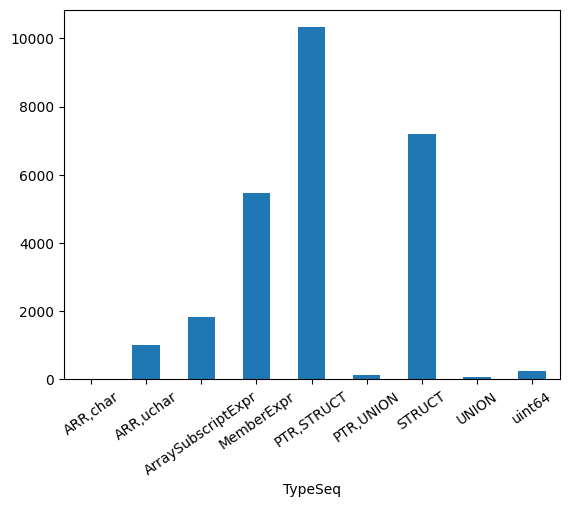

In [22]:
mdf.groupby('TypeSeq').count().FunctionStart.plot(kind='bar',rot=35)

Looks like the distribution doesn't change whether or not we only include aligned data points:

<Axes: title={'center': 'HasStripNodes=True'}, xlabel='TypeSeq'>

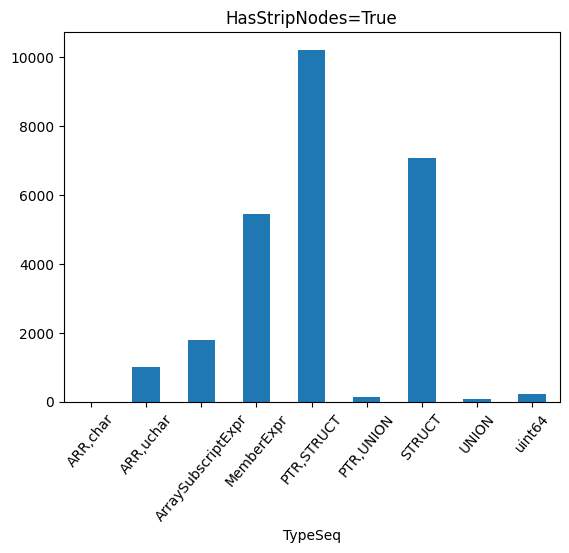

In [23]:
#mdf.groupby('TypeSeq').count().FunctionStart.plot(kind='bar',rot=35)
mdf[mdf.HasStripNodes].groupby('TypeSeq').count().FunctionStart.plot(kind='bar',rot=50,title='HasStripNodes=True')

In [24]:
percent_aligned = len(mdf[mdf.HasStripNodes])/len(mdf)*100
print(f'{percent_aligned:.2f}% of the member expressions align with nodes from the stripped AST')

98.95% of the member expressions align with nodes from the stripped AST


## uint64 cases
This appears to be Ghidra's "fake structure" syntax:
`var._X_Y_`

In [25]:
mexpr = mdf[mdf.TypeSeq=='uint64'].iloc[0].MemberExpr
dref = mexpr.inner[0]
print_ast(mexpr)
dref.referencedDecl

local_d8._1_1_


uint64 local_d8 @ Stack[-0xd8]

## ARR,char cases
This appears to be Ghidra's "fake structure" syntax:
`array_var._X_Y_`

In [26]:
mexpr = mdf[mdf.TypeSeq=='ARR,char'].iloc[0].MemberExpr
dref = mexpr.inner[0]
print_ast(mexpr)
dref.referencedDecl

description._32_8_


char[1024] description @ Stack[-0x4c8]

<Axes: xlabel='InnerKind'>

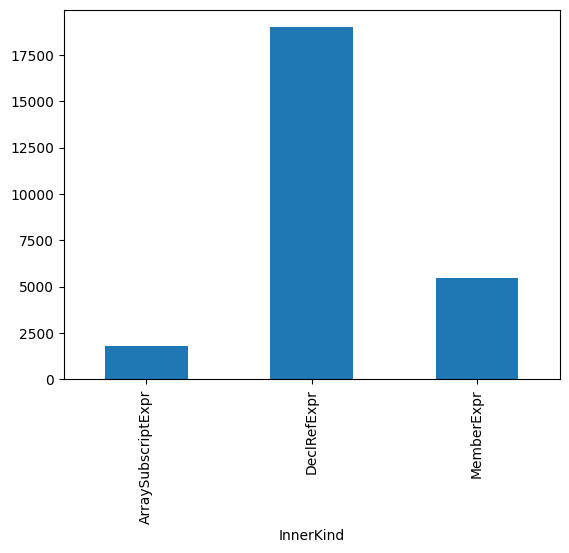

In [27]:
mdf.groupby('InnerKind').count().FunctionStart.plot(kind='bar')

## STRUCT cases
I think this should be our local stack variable cases... (maybe globals are here too)

In [28]:
mdf[mdf.TypeSeq=='STRUCT'].groupby('LocType').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,Offset
LocType,,,,,,,
join,19,19,19,19,19,19,19
ram,3481,3481,3481,3481,3481,3481,3481
stack,2918,2918,2918,2918,2918,2918,2918
unique,788,788,788,788,788,788,788


<Axes: xlabel='LocType'>

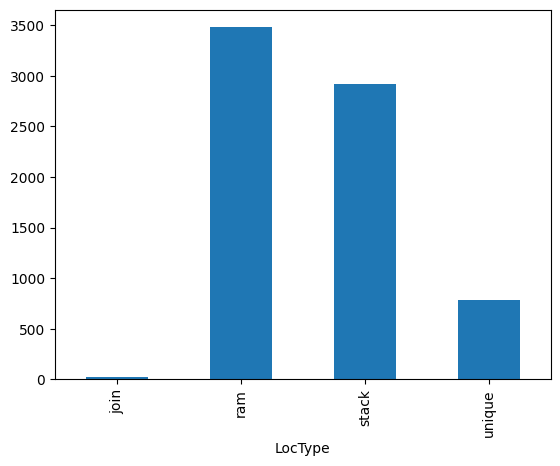

In [29]:
mdf[mdf.TypeSeq=='STRUCT'].groupby('LocType').count().FunctionStart.plot(kind='bar')

In [30]:
# mdf[mdf.TypeSeq=='']

In [31]:
subset = mdf[(mdf.TypeSeq=='STRUCT')&(mdf.LocType=='stack')]
subset

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset
16,1090936,<DeclRef: sheet>...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,0
18,1090936,<DeclRef: sheet>...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,4
20,1090936,<DeclRef: sheet>...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,8
22,1090936,<DeclRef: sheet>...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,12
24,1090936,<DeclRef: sheet>...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,16
...,...,...,...,...,...,...,...,...
26256,1765816,<DeclRef: e>.cod...,[],False,DeclRefExpr,STRUCT,stack,18
26257,1765816,<DeclRef: e>.val...,[<DeclRef: FUN_0...,True,DeclRefExpr,STRUCT,stack,20
26258,1765816,<DeclRef: e>.typ...,[BinaryOperator ...,True,DeclRefExpr,STRUCT,stack,16
26259,1765816,<DeclRef: e>.cod...,[],False,DeclRefExpr,STRUCT,stack,18


In [32]:
ex_row = subset.iloc[4]
mexpr = ex_row.MemberExpr
dref = mexpr.inner[0]
print(f'{mexpr.instr_addr:#x}')
print_ast(mexpr)
dref.referencedDecl
ex_row.StripNodes

0x10a60c
sheet.subtexs


[BinaryOperator =,
 <DeclRef: param_1>,
 <IntegerLiteral: 2 (dtype=int64)>,
 <DeclRef: local_28>]

## PTR,STRUCT Cases

> Can we build a dataset starting with only these variables?

We probably will start by recovering these structures first, then come back for the stack-based/memory-based structs

In [33]:
subset = mdf.loc[(mdf.TypeSeq=='PTR,STRUCT')&(mdf.LocType!='unique'),:]
percent_total = len(subset)/len(mdf)*100
print(f'PTR,STRUCT (non-unique) accounts for {percent_total:.2f}% of the total data')

PTR,STRUCT (non-unique) accounts for 38.09% of the total data


<Axes: title={'center': 'PTR,STRUCT Alignment with Stripped AST'}, xlabel='HasStripNodes', ylabel='Percentage (%)'>

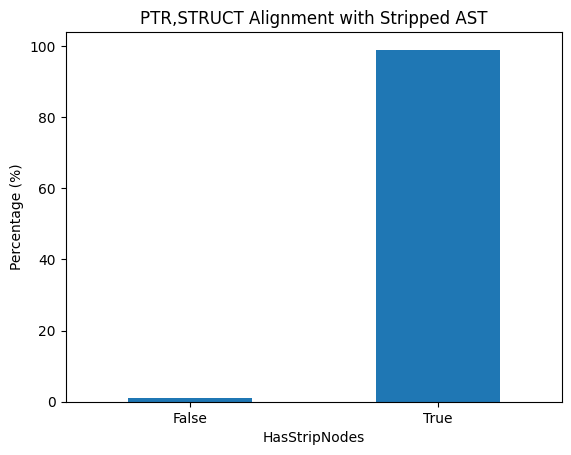

In [34]:
(subset.groupby('HasStripNodes').count()/len(subset)*100).FunctionStart.plot(kind='bar', rot=0, title='PTR,STRUCT Alignment with Stripped AST',
    ylabel='Percentage (%)')

<Axes: title={'center': 'PTR,STRUCT Storage Locations'}, xlabel='LocType', ylabel='Percentage (%)'>

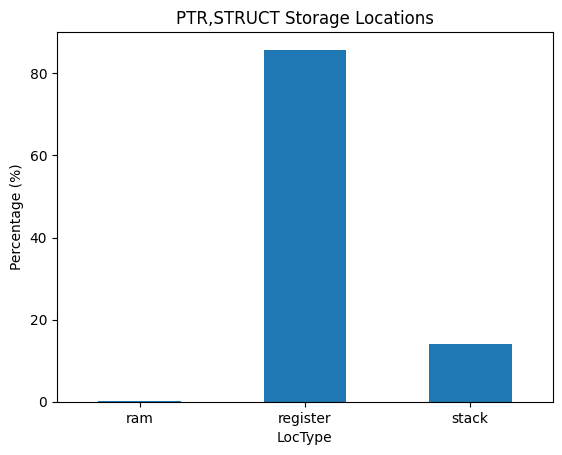

In [35]:
(subset.groupby('LocType').count()/len(subset)*100).FunctionStart.plot(kind='bar',rot=0, title='PTR,STRUCT Storage Locations', ylabel='Percentage (%)')

Remember, OSPREY would be unable to deal with any of these register variables!

In [36]:
num_reg_locs = len(subset[subset.LocType=='register'])
print(f'{num_reg_locs:,} PTR,STRUCT vars stored in registers ({num_reg_locs/len(subset)*100:.2f}% of PTR,STRUCT vars)')

8,577 PTR,STRUCT vars stored in registers (85.75% of PTR,STRUCT vars)


In [37]:
# print_ast()
m = subset.iloc[0].MemberExpr
strip_nodes = subset.iloc[0].StripNodes

print(m)
strip_nodes

<DeclRef: asset>->data (offset=0x8, sid=72057594037927950)


[UnaryOperator *,
 CStyleCastExpr (uint64*),
 BinaryOperator +,
 <DeclRef: lVar2>,
 <IntegerLiteral: 8 (dtype=int64)>]

Here is the member offset and it's parent struct:

In [38]:
print(f'Offset: {m.offset}')
m.parent_struct

Offset: 8


struct asset_t {
	0x0: uint32 uid
	0x8: uchar* data
	0x10: uint32 data_length
	0x18: char* name
	0x20: int32 chunk_start
	0x24: int32 chunk_length
	0x28: uchar fs
	0x29: uchar filled
	0x2a: uchar req
	0x2b: uchar req_free
	0x2c: uchar chunk
}

Can we find a matching IntegerLiteral?

In [39]:
def get_int_literals(strip_nodes:List[ASTNode]) -> List[IntegerLiteral]:
    return [n for n in strip_nodes if isinstance(n, IntegerLiteral)]

def matching_int_literals(int_literals:List[ASTNode], offset:int) -> List[IntegerLiteral]:
    return [x for x in int_literals if x.value == offset]

def collect_int_literals(strip_nodes:List[ASTNode], offset:int):
    int_literals = get_int_literals(strip_nodes)
    if int_literals:
        matches = matching_int_literals(int_literals, offset)
        if matches:
            if len(matches) == 1:
                return 'MATCH'
            return 'MULTIPLE'
        return 'NO_MATCHES'
    return 'NO_LITERALS'

# int_literals = [n for n in strip_nodes if isinstance(n, IntegerLiteral)]
# if not int_literals:
#     print(f'No integer literals at this address')
# else:
#     offset_matches = [x for x in int_literals if x.value == m.offset]
#     if not offset_matches:
#         print(f'No integer literals match offset of {m.offset}')
#     elif len(offset_matches) > 1:
#         print(f'Multiple literals match offset of {m.offset}')
#     else:
#         print(f'Found match! {offset_matches[0]}')


In [40]:
# subset.loc[:,'IntLitMatches'] = subset.apply(lambda x: collect_int_literals(x.StripNodes, x.MemberExpr.offset), axis=1)
# subset.loc[:,'test'] = subset.apply(lambda x: collect_int_literals(x.StripNodes, x.MemberExpr.offset), axis=1)
subset['IntLitMatches'] = subset.apply(lambda x: collect_int_literals(x.StripNodes, x.MemberExpr.offset), axis=1)

Let's filter out the unaligned cases from here on out:

In [41]:
subset = subset.loc[subset.HasStripNodes,:]
subset

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset,IntLitMatches
11,1090825,<DeclRef: asset>...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",register,8,MATCH
12,1090825,<DeclRef: asset_...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",register,8,MATCH
13,1090936,<DeclRef: asset>...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",register,8,MATCH
14,1090936,<DeclRef: asset>...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",register,16,MATCH
15,1090936,<DeclRef: __retu...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",register,0,NO_LITERALS
...,...,...,...,...,...,...,...,...,...
26195,1764366,<DeclRef: js>->l...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",register,240,MATCH
26212,1764501,<DeclRef: pdVar4...,[<DeclRef: pdVar...,True,DeclRefExpr,"PTR,STRUCT",register,19,NO_LITERALS
26213,1764501,<DeclRef: pdVar4...,[<DeclRef: pdVar...,True,DeclRefExpr,"PTR,STRUCT",register,19,NO_LITERALS
26245,1765816,<DeclRef: js>->l...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",register,240,MATCH


In [42]:
subset.groupby('IntLitMatches').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset
IntLitMatches,,,,,,,,
MATCH,4431,4431,4431,4431,4431,4431,4431,4431
MULTIPLE,64,64,64,64,64,64,64,64
NO_LITERALS,1003,1003,1003,1003,1003,1003,1003,1003
NO_MATCHES,4395,4395,4395,4395,4395,4395,4395,4395


## NO_LITERALS Cases
Ah! Remember that the first member (at offset `0`) is special...we won't see an offset! :)

In [43]:
subset[subset.IntLitMatches=='NO_LITERALS'].iloc[0].MemberExpr

<DeclRef: __return_storage_ptr__>->id (offset=0x0, sid=72057594037927968)

In [44]:
subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)].groupby('LocType')[['FunctionStart']].count()

,FunctionStart
LocType,
register,46
stack,2


Most cases (~85% here) of the NO_LITERALS category are for member offsets of 0 (the first member)

Offset
0       955
2         4
4        32
6         1
8         2
19        2
56        1
161       1
221       1
500       2
6728      2
Name: FunctionStart, dtype: int64

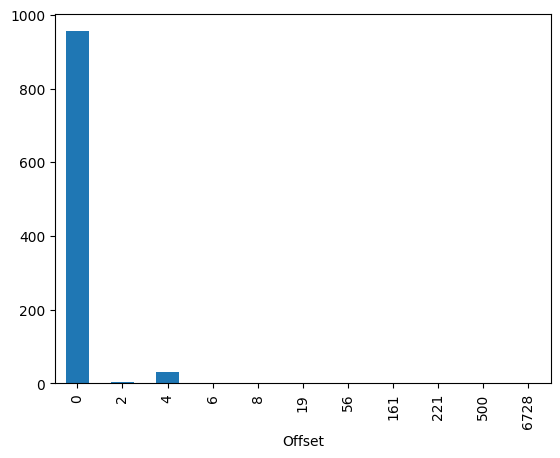

In [45]:
subset[subset.IntLitMatches=='NO_LITERALS'].groupby('Offset')['FunctionStart'].count().plot(kind='bar')
subset[subset.IntLitMatches=='NO_LITERALS'].groupby('Offset')['FunctionStart'].count()

In [46]:
#subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)]

Oh...but only 48 of these are "real" cases (not unique variables)

In [47]:
len(subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)&(subset.LocType!='unique')])

48

### "Data move" instructions moving multiple members
This situation results in no explicit access to the member offset, because a larger instruction
is moving the data for both smaller members at once

In [48]:
print(hex(1090936))
print_ast(subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)].iloc[0].MemberExpr.parent)
subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)].iloc[0].MemberExpr

0x10a578
__return_storage_ptr__->width = sheet.width


<DeclRef: __return_storage_ptr__>->width (offset=0x4, sid=72057594037927968)

In [49]:
hex(subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)].iloc[0].MemberExpr.instr_addr)

'0x10a5fd'

In [50]:
row = subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)].iloc[2]

def show_row(row):
    print(f'Function: {row.FunctionStart:#x}')
    print(f'Instruction: {row.MemberExpr.instr_addr:#x}')
    print(f'Member: {row.MemberExpr}')
    print(f'Offset: {row.MemberExpr.offset} ({row.MemberExpr.offset:#x})')
    print_ast(row.MemberExpr.parent)
    print(f'Stripped AST nodes:')
    for n in row.StripNodes:
        print(f'\t{n}')

show_row(row)

Function: 0x11f82a
Instruction: 0x11f8b7
Member: <DeclRef: f>->mode_config (offset=0x1f4, sid=360287970189639724)
Offset: 500 (0x1f4)
f->mode_config + mode
Stripped AST nodes:
	BinaryOperator +


In [51]:
subset[(subset.IntLitMatches=='NO_LITERALS')&(subset.Offset>0)].iloc[1].MemberExpr.instr_addr

1172044

In [52]:
subset.groupby('IntLitMatches').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset
IntLitMatches,,,,,,,,
MATCH,4431,4431,4431,4431,4431,4431,4431,4431
MULTIPLE,64,64,64,64,64,64,64,64
NO_LITERALS,1003,1003,1003,1003,1003,1003,1003,1003
NO_MATCHES,4395,4395,4395,4395,4395,4395,4395,4395


## NO_MATCHES Cases

<Axes: title={'center': 'NO_MATCHES'}, xlabel='LocType'>

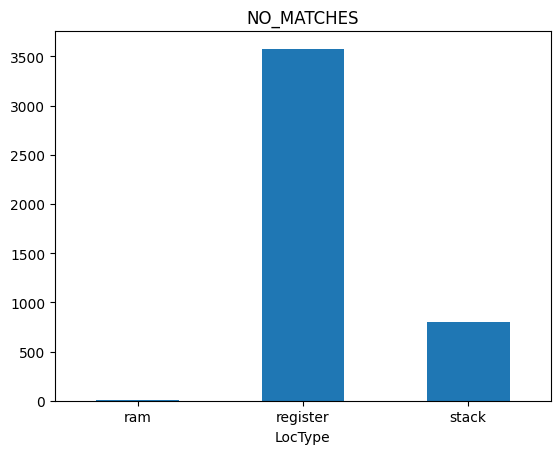

In [53]:
subset[subset.IntLitMatches=='NO_MATCHES'].groupby('LocType').count().FunctionStart.plot(kind='bar', rot=0, title='NO_MATCHES')
#.iloc[0].MemberExpr

In [54]:
row = subset[subset.IntLitMatches=='NO_MATCHES'].iloc[8]
show_row(row)
# row.StripNodes
# collect_int_literals(row.StripNodes, row.MemberExpr.offset)
row.MemberExpr.parent_struct

Function: 0x10a803
Instruction: 0x10a85d
Member: <DeclRef: particle>->frame (offset=0x30, sid=72057594037927978)
Offset: 48 (0x30)
particle->frame = uVar1
Stripped AST nodes:
	BinaryOperator =
	<DeclRef: param_2>
	<IntegerLiteral: 12 (dtype=int64)>
	<DeclRef: fVar1>


struct r_particle {
	0x0: float life
	0x4: float last
	0x8: float rotation
	0xc: float[2] position
	0x14: float[2] size
	0x1c: float[2] velocity
	0x24: float[2] direction
	0x2c: uchar layer
	0x30: uint32 frame
	0x34: float[4] color
}

# Stack variables
Before dismissing this completely...*is there any chance we could recover **stack-based** `PTR->STRUCT` cases?*

In [55]:
stack_sptrs = mdf[(mdf.LocType=='stack')&(mdf.TypeSeq=='PTR,STRUCT')]
stack_sptrs['IntLitMatches'] = stack_sptrs.apply(lambda x: collect_int_literals(x.StripNodes, x.MemberExpr.offset), axis=1)
stack_sptrs

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset,IntLitMatches
82,1091960,<DeclRef: en>->e...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,188,MATCH
83,1091960,<DeclRef: en>->e...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,188,NO_MATCHES
84,1091960,<DeclRef: en>->e...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,188,MATCH
85,1091960,<DeclRef: en>->e...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,188,NO_MATCHES
86,1091960,<DeclRef: en>->e...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,188,MATCH
...,...,...,...,...,...,...,...,...,...
25610,1750673,<DeclRef: u>->do...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,56,NO_MATCHES
25612,1750673,<DeclRef: u>->ha...,[BinaryOperator ...,True,DeclRefExpr,"PTR,STRUCT",stack,64,NO_MATCHES
25615,1750673,<DeclRef: closes...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",stack,64,MATCH
25955,1757369,<DeclRef: result...,[UnaryOperator *...,True,DeclRefExpr,"PTR,STRUCT",stack,0,NO_LITERALS


In [56]:
stack_sptrs[(stack_sptrs.IntLitMatches!='MATCH')&(stack_sptrs.Offset>0)].groupby('IntLitMatches').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,TypeSeq,LocType,Offset
IntLitMatches,,,,,,,,
MULTIPLE,2,2,2,2,2,2,2,2
NO_LITERALS,19,19,19,19,19,19,19,19
NO_MATCHES,777,777,777,777,777,777,777,777


> 1. Do stack-based PTR->STRUCT types have the same form? Always? 
    > - What about optimized code?
> 2. Is the form for PTR->STRUCT **always** `*(TYPE)(var + OFFSET)`?
    > - If so, then just harvest this programmatically (check accuracy)
    > - If not (or if optimization changes this) then there is **value** in a model that can learn the mapping(s)

In [57]:
row = stack_sptrs[stack_sptrs.IntLitMatches=='NO_MATCHES'].iloc[4]
show_row(row)

row.MemberExpr.parent_struct

print_ast(row.MemberExpr.parent)
row.MemberExpr.parent

# print_ast(row.StripNodes[-1].parent.parent.parent)
tudecl = row.StripNodes[-1].find_root_node()
# FindAllVarRefs()
# refs = FindAllVarRefs(row.StripNodes[-2].referencedDecl.name).visit(tudecl)

# print_ast(refs[5].parent.parent.parent.parent.parent)

# refs[5].parent.parent.parent.render()

# [r for r in FindAllVarRefs('local_60').visit(tudecl) if r.instr_addr == 0x10abff][0].parent.parent.parent.render()
FindAllVarRefs('puVar1').visit(tudecl)
# tudecl.inner[-1].inner[0].inner[0].inner
row.StripNodes[-3].referencedDecl

Function: 0x10a978
Instruction: 0x10ac79
Member: <DeclRef: en>->sprite (offset=0x0, sid=72057594037927994)
Offset: 0 (0x0)
en->sprite.size
Stripped AST nodes:
	BinaryOperator =
	<DeclRef: puVar1>
	<IntegerLiteral: 1 (dtype=int64)>
	<DeclRef: local_130>
en->sprite.size


uint64* puVar1 @ LocType=unique,Reg=,Off=268437023

### Ok...but what about *other* pointer hierarchies?
This is very promising for PTR,STRUCT...but what about others?

- ARR,STRUCT
- ARR,PTR,STRUCT
- PTR,PTR,STRUCT
- PTR,ARR,STRUCT
- ...

In [61]:
mdf.groupby('TypeSeq').count()

,FunctionStart,MemberExpr,StripNodes,HasStripNodes,InnerKind,LocType,Offset
TypeSeq,,,,,,,
"ARR,char",2,2,2,2,2,2,2
"ARR,uchar",1012,1012,1012,1012,1012,1012,1012
ArraySubscriptExpr,1813,1813,1813,1813,1813,1813,1813
MemberExpr,5461,5461,5461,5461,5461,5461,5461
"PTR,STRUCT",10329,10329,10329,10329,10329,10329,10329
"PTR,UNION",134,134,134,134,134,134,134
STRUCT,7206,7206,7206,7206,7206,7206,7206
UNION,78,78,78,78,78,78,78
uint64,227,227,227,227,227,227,227


**TODO: - look at `MemberExpr` rows...these are probably nested member accesses**

In [101]:
row = mdf[mdf.TypeSeq=='ArraySubscriptExpr'].iloc[80]
print_ast(row.MemberExpr)

show_row(row)
row.MemberExpr.parent_struct
row.StripNodes[-1].parent.render()
row.MemberExpr.inner[0].inner[0].referencedDecl

peVar4[i_3].damage_timer
Function: 0x113173
Instruction: 0x113f74
Member: <astlib.ast.ArraySubscriptExpr object at 0x7fc3ef396850>.damage_timer (offset=0xe0, sid=72057594037927994)
Offset: 224 (0xe0)
peVar4[i_3].damage_timer = 750.0
Stripped AST nodes:
	BinaryOperator =
	UnaryOperator *
	CStyleCastExpr (uint32*)
	BinaryOperator +
	<DeclRef: lVar6>
	<IntegerLiteral: 224 (dtype=int64)>
	<IntegerLiteral: 1144750080 (dtype=uint32)>


enemy_t* peVar4 @ LocType=register,Reg=rax,Off=0

In [59]:
memberexprs

# print_ast(memberexprs[1])
# m = memberexprs[1]
# print(f'member expr @ {m.instr_addr:#x}')
# # m.inner[0].referencedDecl

[]

In [60]:
m.parent_struct

struct asset_t {
	0x0: uint32 uid
	0x8: uchar* data
	0x10: uint32 data_length
	0x18: char* name
	0x20: int32 chunk_start
	0x24: int32 chunk_length
	0x28: uchar fs
	0x29: uchar filled
	0x2a: uchar req
	0x2b: uchar req_free
	0x2c: uchar chunk
}